# Required imports

In [1]:
# Required imports
from collections import namedtuple
import numpy as np
import datetime
from netCDF4 import Dataset
import configparser
from matplotlib import pyplot as plt
from cftime import num2pydate
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pylag.regrid import regridder
from pylag.processing.ncview import Viewer
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure
from pylag.processing.utils import get_grid_bands

# Setting particle initial positions

In [2]:
import os
data_dir = '/home/samin/data/FVCOME_OUTPUT'.format(os.environ['HOME'])

from pylag.processing.coordinate import get_epsg_code, utm_from_lonlat, lonlat_from_utm
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group

# Keep a copy of the cwd
cwd = os.getcwd()
# Create run directory
simulation_dir = '/home/samin/data/FVCOME_OUTPUT/simulations/horon'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# The group ID of this particle set
group_id = 1

# Lat and lon coordiantes for the centre of the release zone
#lat = 45.6342671
#lon = 275.790956
lat = 45.6394448
lon = 275.80146279999997

# Convert to UTM coordinates
#epsg_code = get_epsg_code(lon, lat)
#epsg_code = '4978' # Geocentric coordinate system for World/cartesian
#easting, northing, _ = utm_from_lonlat([lon], [lat], epsg_code=epsg_code)

# Release zone radius (degree)
radius = 0.01

# Target number of particles to be released. Only a target,
# since we are evenly distributing particles in the release
# zone, which has no unique solution.
n_particles_target = 1000

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [lon, lat],
                                           n_particles = n_particles_target,
                                           depth = depth_below_surface,
                                           random = False)

# Get the actual number of particles
n_particles = surface_release_zone.get_number_of_particles()

# Create input sub-directory
input_dir =  '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Output filename
file_name = '{}/initial_positions_huron.dat'.format(input_dir)

# Write data to file
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           surface_release_zone.get_eastings(),
                                           surface_release_zone.get_northings(),
                                           surface_release_zone.get_depths())

# Creating a FVCOM grid metrics file
When running with a new input dataset, it is necessary to generate a grid metrics file. The grid metrics file holds information about the grid on which data are defined. PyLag reads this file in during model start up. The data is pre-generated, so that the grid information can be reused in later simulations using the same input dataset. This avoids incurring repeated costs associated with generating the data. As stated above, a grid metrics file for this example has been pre-generated; indeed, it was used to create the above plot of the domain’s bathymetry. However, for the sake of completeness, we regenerate the grid metrics file so it is clear how this is done in an end-to-end example. To generate a new FVCOM grid metrics file, we need two types of file: an example FVCOM output file, and the file that lists the location of the domain’s open boundary nodes

In [3]:
from pylag.grid_metrics import create_fvcom_grid_metrics_file

# An example FVCOM output file
fvcom_file_name = '/home/samin/data/FVCOME_OUTPUT/fvcome_houron_estuary_0001.nc'

# The file listing the location of open boundary nodes
#obc_file_name = '/home/samin/data/FVCOME_OUTPUT/fvcom_tamar_estuary_obc.dat'
obc_file_name = '/home/samin/data/FVCOME_OUTPUT/obc.dat'
# The name of the output file
#grid_metrics_file_name = f'{input_dir}/grid_metrics_huron2.nc'
grid_metrics_file_name = f'{input_dir}/grid_metrics_huron_node2.nc'
# Generate the file
create_fvcom_grid_metrics_file(fvcom_file_name, obc_file_name = obc_file_name,
                               grid_metrics_file_name=grid_metrics_file_name)

Creating FVCOM grid metrics file /home/samin/data/FVCOME_OUTPUT/simulations/horon/input/grid_metrics_huron_node2.nc
INFO - detected longitudes greater than 180.0 in variable lon. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.
INFO - detected longitudes greater than 180.0 in variable lonc. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.
INFO - nbe variable not found in the FVCOM file. The nbe variable will be reconstructed from the nv variable.
Grid has 51110 nodes on the open boundary


In [36]:
fvcom_file_name = '/home/samin/data/FVCOME_OUTPUT/081700_0001.nc'

'/home/samin/data/FVCOME_OUTPUT/081700_0001.nc'

# see the initial positions of particles
we can simply plot them. Note the ordered scattering of particles within the circular release zone, which is clearly visibile after zooming in on the release zone.

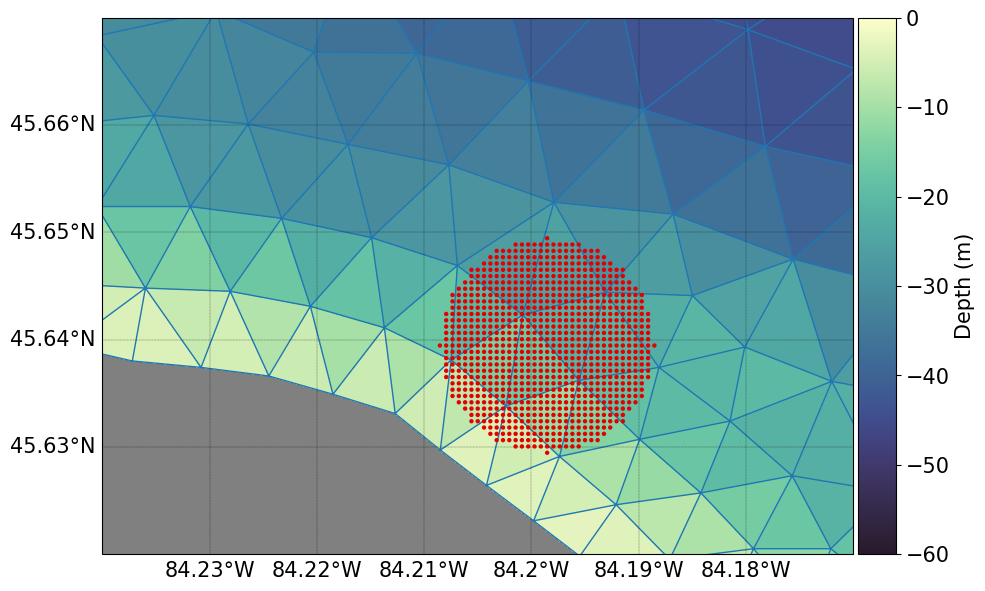

In [4]:
# getting lons and lats
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure, colourmap

#lons, lats = lonlat_from_utm(surface_release_zone.get_eastings(),
                             #surface_release_zone.get_northings(),
                           # epsg_code=epsg_code)
lons = surface_release_zone.get_eastings()
lats = surface_release_zone.get_northings()
# Create figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(),
                       font_size=font_size, bg_color='gray')


#Grid metrics file name
#grid_metrics_file_name = f"{input_dir}/grid_metrics_huron2.nc"
#grid I created with new nodes
grid_metrics_file_name = f"{input_dir}/grid_metrics_huron_node.nc"
# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
del(ds)

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
extents = np.array([275.76,275.83, 45.62,45.67], dtype=float)
#extensts = np.array([-84,-81.3, 43,46], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0.0, cmap=cmap)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Plot particle initial positions
scatter = plotter.scatter(ax, lons, lats, s=10, color='#e50000', edgecolors='none')
plt.savefig('/home/samin/data/figs/initial_position_water.jpg')

# Creating the run configuration
When running applied examples, run configuration parameters are typically set in a run configuration file. Examples of PyLag run configuration files can be found in PyLag’s resources directory, which ships with the code. For this example, a run configuration file has been provided. The file includes lots of comments, so we won’t print it’s full contents here. Instead, we will use configparser to look at a few settings specific to the example. First, we read in the file, then we print out some of the key options for the run:

In [5]:
import configparser
config_file_name = '/home/samin/data/FVCOME_OUTPUT/confings/huron.cfg'


cf = configparser.ConfigParser()
cf.read(config_file_name)

# Start time
print('Start time: {}'.format(cf.get('SIMULATION', 'start_datetime')))

# End time
print('End time: {}'.format(cf.get('SIMULATION', 'end_datetime')))

# Specify that this is a forward tracking experiment
print('Time direction: {}'.format(cf.get('SIMULATION', 'time_direction')))

# We will do a single run, rather than an ensemble run
print('Number of particle releases: {}'.format(cf.get('SIMULATION', 'number_of_particle_releases')))

# Use depth restoring, and restore particle depths to the ocean surface
print('Use depth restoring: {}'.format(cf.get('SIMULATION', 'depth_restoring')))
print('Restore particles to a depth of: {} m'.format(cf.get('SIMULATION', 'fixed_depth')))

# Specify that we are working with FVCOM in cartesian coordinates
print('Model name: {}'.format(cf.get('OCEAN_DATA', 'name')))
print('Coordinate system: {}'.format(cf.get('SIMULATION', 'coordinate_system')))

# Set the location of the grid metrics and input files
print('Data directory: {}'.format(cf.get('OCEAN_DATA', 'data_dir')))
print('Path to grid metrics file: {}'.format(cf.get('OCEAN_DATA', 'grid_metrics_file')))
print('File name stem of input files: {}'.format(cf.get('OCEAN_DATA', 'data_file_stem')))
      
# Do an advection only run using a RK$ intergration scheme 
print('Numerical method: {}'.format(cf.get('NUMERICS', 'num_method')))
print('Iterative method: {}'.format(cf.get('NUMERICS', 'iterative_method')))

Start time: 2022-11-26 01:00:00
End time: 2022-11-29 00:00:00
Time direction: forward
Number of particle releases: 10
Use depth restoring: True
Restore particles to a depth of: 0.0 m
Model name: FVCOM
Coordinate system: geographic
Data directory: /home/samin/data/FVCOME_OUTPUT
Path to grid metrics file: /home/samin/data/FVCOME_OUTPUT/simulations/horon/input/grid_metrics_huron_node.nc
File name stem of input files: fvcome_houron_estuary_0001
Numerical method: standard
Iterative method: Adv_RK4_3D


From the above options, it can be seen we hvae not yet specified a directory within which the model can find FVCOM output files, or the location of the grid metrics file. We will set these using data_dir, and save the new config file in the simulation directory. All other paths are relative, and can be left as they are.

In [6]:
cf.set('OCEAN_DATA', 'data_dir', data_dir)
cf.set('OCEAN_DATA', 'grid_metrics_file', grid_metrics_file_name)

# Save a copy in the simulation directory
with open(f"{simulation_dir}/pylag.cfg", 'w') as config:
    cf.write(config)

# Running the model 
With the run configuration file saved, we can now run the example. While PyLag can be used interactivatly, it is most commonly launched from the command line like so:

In [7]:
# Change to the run directory
os.chdir(f"{simulation_dir}")

# Run the model
!{"python -m pylag.main -c pylag.cfg"}

# Return to the cwd
os.chdir(cwd)


Starting ensemble member 1 ...
Progress:
100% |###########################################|

Starting ensemble member 2 ...
Progress:
100% |###########################################|

Starting ensemble member 3 ...
Progress:
100% |###########################################|

Starting ensemble member 4 ...
Progress:
100% |###########################################|

Starting ensemble member 5 ...
Progress:
100% |###########################################|

Starting ensemble member 6 ...
Progress:
100% |###########################################|

Starting ensemble member 7 ...
Progress:
100% |###########################################|

Starting ensemble member 8 ...
Progress:
100% |###########################################|

Starting ensemble member 9 ...
Progress:
100% |###########################################|

Starting ensemble member 10 ...
Progress:
100% |###########################################|


# Result visualization
With the model having run, the final step is to visulise the result. Here, we produce a simple plot of particle pathlines over the course of the simulation. Within the config file, we specified that outputs should be saved in an directory called output. To make the plot, we leverage plotting functionlity provided with the processing sub-package

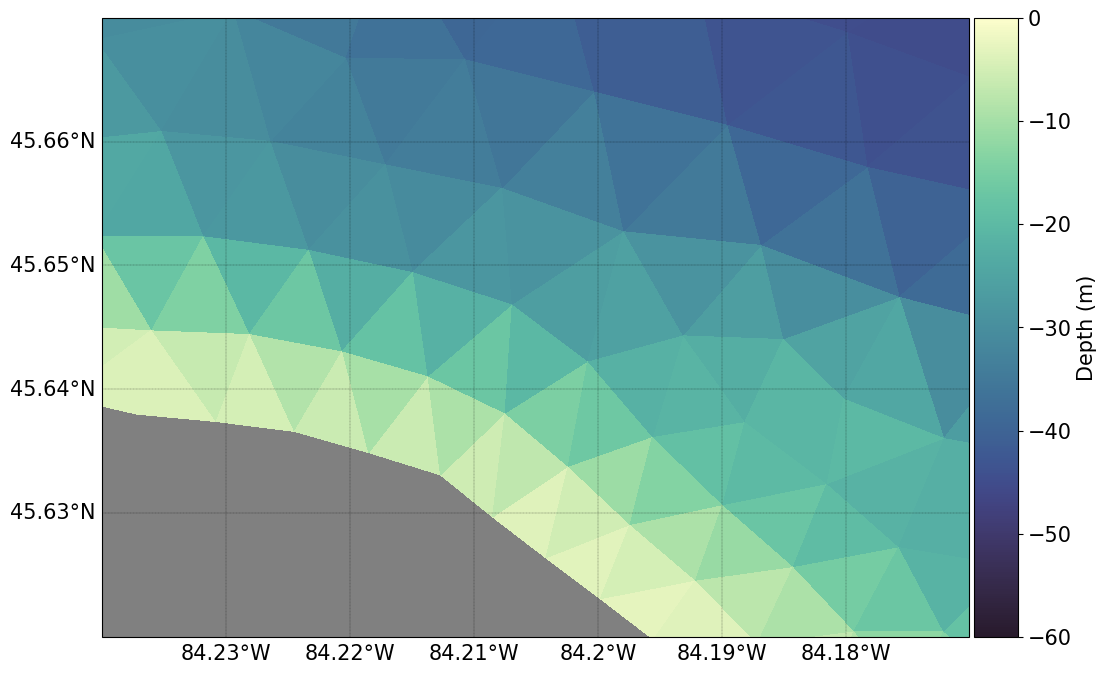

In [12]:
from datetime import timedelta

from pylag.processing.ncview import Viewer


file_name = '/home/samin/data/FVCOME_OUTPUT/simulations/horon/output/pylag_1.nc'

# Time of flight
time_of_flight = timedelta(hours=12)
font_size = 15
# Plot extents
extents = np.array([275.76,275.83, 45.62,45.67], dtype=float)
#extents = np.array([-145, 245, 40, 46.4], dtype=float)
fig, ax = create_figure(figure_size=(30., 30.), projection=ccrs.PlateCarree(),
                        font_size=font_size, bg_color='gray')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot the bathymetry again. We'll overlay pathlines on top of this.
plotter.plot_field(ax, bathy, extents= extents, add_colour_bar=True, cb_label='Depth (m)',
                   vmin=-60., vmax=0., cmap=cmap)

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=900)

# Get time index
date = viewer.date[0] + time_of_flight
time_index = viewer.date.tolist().index(date)
n_times = viewer.date[:time_index+1].shape[0]

# Convert positions into lons/lats
#lons, lats = lonlat_from_utm(viewer('latitude')[time_index, :].squeeze(),
                            # viewer('longitude')[time_index, :].squeeze(), epsg_code=epsg_code)
lons,lats = [viewer('longitude')[time_index,:].squeeze(), viewer('latitude')[time_index, :].squeeze()]

# Plot particle final positions
ax, scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='none')

# Convert all pathline coordinates into lons/lats
#for i in range(0,60):
    #lons_paths, lats_paths = (viewer('longitude')[:i+1, :],
                                   # viewer('latitude')[:i+1, :])
lons_paths, lats_paths = (viewer('longitude')[:time_index+1, :],
                                         viewer('latitude')[:time_index+1, :])
# Add path lines
ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.10, alpha=1, color='#0504aa')
plt.savefig('/home/samin/data/figs/result_boundry_horizontal_22112629.jpg',dpi=300)

In [18]:
plt.savefig('/home/samin/data/figs/result_timechange.jpg')

<Figure size 640x480 with 0 Axes>